# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data load

In [2]:
expression_data = pd.read_csv('../TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)  # Gene expression (TPM)
methylation_data = pd.read_csv('../TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)  # DNA methylation
copy_number_data = pd.read_csv('../TCGA-SARC.gene-level_absolute.tsv', sep='\t', index_col=0)  # Gene-level copy number (ABSOLUTE)
protein_data = pd.read_csv('../TCGA-SARC.protein.tsv', sep='\t', index_col=0)  # Protein expression

try:
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except Exception as e:
    print("Error while loading phenotype_data:", e)
    with open('../TCGA-SARC.clinical.tsv', 'r') as f:
        for i, line in enumerate(f):
            try:
                pd.read_csv(pd.compat.StringIO(line), sep='\t')
            except Exception as row_e:
                print(f"Error in line {i}: {row_e}")
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Data shapes:")
print(f"Expression data: {expression_data.shape}")
print(f"Methylation data: {methylation_data.shape}")
print(f"Copy number data: {copy_number_data.shape}")
print(f"Protein data: {protein_data.shape}")
print(f"Phenotype data: {phenotype_data.shape}")

Data shapes:
Expression data: (60660, 265)
Methylation data: (486427, 269)
Copy number data: (60623, 248)
Protein data: (487, 226)
Phenotype data: (272, 78)


# Sample Matching

In [3]:
# subtype_columns = [col for col in phenotype_data.columns if any(keyword in col.lower() 
#                    for keyword in ['subtype', 'histology', 'type', 'classification'])]

# print("Subtype-related columns:")
# for col in subtype_columns:
#     print(f"- {col}")
#     print(phenotype_data[col].value_counts())
#     print()


print("Checking for missing values in phenotype data:")
missing_values = phenotype_data.isnull().sum()
print(missing_values[missing_values > 0])

print()
print("Checking sample overlap between different omics data:")

samples_expression = set(expression_data.columns)
samples_methylation = set(methylation_data.columns)
samples_cnv = set(copy_number_data.columns)
samples_clinical = set(phenotype_data.index)
samples_protein = set(protein_data.columns)
print("Sample overlap:")
print(f"Expression samples: {len(samples_expression)}")
print(f"Methylation samples: {len(samples_methylation)}")
print(f"CNV samples: {len(samples_cnv)}")
print(f"Clinical samples: {len(samples_clinical)}")
print(f"Protein samples: {len(samples_protein)}")

# Find common samples across all omics
common_samples = list(samples_expression.intersection(samples_methylation, samples_cnv, samples_clinical, samples_protein))
print(f"Common samples across all omics: {len(common_samples)}")

# Filter data to keep only common samples
expression_data = expression_data[common_samples]
methylation_data = methylation_data[common_samples]
copy_number_data = copy_number_data[common_samples]
protein_data = protein_data[common_samples]
phenotype_data = phenotype_data.loc[common_samples]



Checking for missing values in phenotype data:
days_to_birth.demographic                                      1
year_of_birth.demographic                                      4
days_to_death.demographic                                    170
year_of_death.demographic                                    195
entity_submitter_id.annotations                              254
notes.annotations                                            254
submitter_id.annotations                                     254
classification.annotations                                   254
entity_id.annotations                                        254
created_datetime.annotations                                 254
annotation_id.annotations                                    254
entity_type.annotations                                      254
updated_datetime.annotations                                 254
case_id.annotations                                          254
state.annotations                          

# Data preprocessing

### Check Null value

In [4]:
#Check for null values of expression data
print("Checking for null values in expression data:")
null_expression = expression_data.isnull().sum().sum()
if null_expression > 0:
    print(f"Expression data contains {null_expression} null values.")
else:   
    print("No null values found in expression data.")
print()


# Check for null values in methylation data
print("Checking for null values in methylation data:")
null_methylation = methylation_data.isnull().sum().sum()
if null_methylation > 0:
    print(f"Methylation data contains {null_methylation} null values.")
else:
    print("No null values found in methylation data.")
print()


# Check for null values in copy number data
print("Checking for null values in copy number data:")
null_copy_number = copy_number_data.isnull().sum().sum()
if null_copy_number > 0:
    print(f"Copy number data contains {null_copy_number} null values.")
else:
    print("No null values found in copy number data.")
max_value = copy_number_data.max().max()
min_value = copy_number_data.min().min()

print(f"Maximum CNV value: {max_value}")
print(f"Minimum CNV value: {min_value}")
print()


# Check for null values in protein data
print("Checking for null values in protein data:")
null_protein = protein_data.isnull().sum().sum()
if null_protein > 0:
    print(f"Protein data contains {null_protein} null values.")
else:
    print("No null values found in protein data.")
print()


# Check for null values in phenotype data
print("Checking for null values in phenotype data:")
null_phenotype = phenotype_data.isnull().sum().sum()
if null_phenotype > 0:
    print(f"Phenotype data contains {null_phenotype} null values.")
else:
    print("No null values found in phenotype data.")



Checking for null values in expression data:
No null values found in expression data.

Checking for null values in methylation data:
Methylation data contains 16814049 null values.

Checking for null values in copy number data:
Copy number data contains 855388 null values.
Maximum CNV value: 7.0
Minimum CNV value: 0.0

Checking for null values in protein data:
Protein data contains 6300 null values.

Checking for null values in phenotype data:
Phenotype data contains 3389 null values.
Maximum CNV value: 7.0
Minimum CNV value: 0.0

Checking for null values in protein data:
Protein data contains 6300 null values.

Checking for null values in phenotype data:
Phenotype data contains 3389 null values.


### Process data

In [5]:
# expression data preprocessing -------------------------------------------------->

# Log2 transform
expression_data_log = np.log2(expression_data + 1)

# Z-score standardization
scaler_expr = StandardScaler()
expression_data_scaled = pd.DataFrame(
    scaler_expr.fit_transform(expression_data_log.T).T,
    index=expression_data_log.index,
    columns=expression_data_log.columns
)

from sklearn.feature_selection import VarianceThreshold


# Methylation data preprocessing -------------------------------------------------->

# Droping probes with more than 25% missing values 
methylation_data = methylation_data.dropna(thresh=0.75 * methylation_data.shape[1], axis=0)
# DO NOT fill na for MOFA
# methylation_data = methylation_data.apply(lambda x: x.fillna(x.median()), axis=1)

# Remove low-variance methylation probes
selector = VarianceThreshold(threshold=0.01)
methylation_filtered = pd.DataFrame(
    selector.fit_transform(methylation_data.T).T,
    index=methylation_data.index[selector.get_support()],
    columns=methylation_data.columns
)

# Z-score standardization
scaler_meth = StandardScaler()
methylation_scaled = pd.DataFrame(
    scaler_meth.fit_transform(methylation_filtered.T).T,
    index=methylation_filtered.index,
    columns=methylation_filtered.columns
)


# Copy number data preprocessing -------------------------------------------------->

# Drop genes with >20% missing values
gene_missing_threshold = 0.2
copy_number_data_filtered = copy_number_data.loc[
    copy_number_data.isnull().mean(axis=1) < gene_missing_threshold
]
# DO NOT fill null values for MOFA
# copy_number_imputed = copy_number_data_filtered.apply(
#     lambda row: row.fillna(row.median()), axis=1
# )
copy_number_imputed = copy_number_data_filtered

# Standardize across samples
scaler_cnv = StandardScaler()
copy_number_scaled = pd.DataFrame(
    scaler_cnv.fit_transform(copy_number_imputed.T).T,
    index=copy_number_imputed.index,
    columns=copy_number_imputed.columns
)


# Protein data preprocessing ------------------------------------------------------>
# Drop proteins with >20% missing values
protein_missing_threshold = 0.2
protein_data_filtered = protein_data.loc[
    protein_data.isnull().mean(axis=1) < protein_missing_threshold
]
# DO NOT fill null values for MOFA
# protein_imputed = protein_data_filtered.apply(
#     lambda row: row.fillna(row.median()), axis=1
# )
protein_imputed = protein_data_filtered

# Standardize across samples
scaler_protein = StandardScaler()
protein_scaled = pd.DataFrame(
    scaler_protein.fit_transform(protein_imputed.T).T,
    index=protein_imputed.index,
    columns=protein_imputed.columns
)

In [6]:
# Phenotype data preprocessing -------------------------------------------------->
subtype_column = 'primary_diagnosis.diagnoses'
print(f"Using '{subtype_column}' as the subtype column")
print(f"Subtype distribution:\n{phenotype_data[subtype_column].value_counts()}")
print()
# Only keep selected subtypes
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
 ]
phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
print(f"Filtered to selected subtypes. Remaining samples: {len(phenotype_data)}")
# Checking missing values in the subtype column
missing_subtypes = phenotype_data[subtype_column].isnull().sum()
print(f"Missing values in subtype column: {missing_subtypes}")
if missing_subtypes > 0:
    phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])
    print(f"Removed {missing_subtypes} samples with missing subtypes")
    print(f"Remaining samples: {len(phenotype_data_clean)}")
else:
    phenotype_data_clean = phenotype_data.copy()
    print("No missing subtypes found")

Using 'primary_diagnosis.diagnoses' as the subtype column
Subtype distribution:
primary_diagnosis.diagnoses
Leiomyosarcoma, NOS                        76
Dedifferentiated liposarcoma               49
Undifferentiated sarcoma                   32
Fibromyxosarcoma                           20
Malignant fibrous histiocytoma             11
Malignant peripheral nerve sheath tumor     9
Synovial sarcoma, spindle cell              4
Giant cell sarcoma                          3
Pleomorphic liposarcoma                     2
Synovial sarcoma, biphasic                  1
Liposarcoma, well differentiated            1
Myxoid leiomyosarcoma                       1
Synovial sarcoma, NOS                       1
Name: count, dtype: int64

Filtered to selected subtypes. Remaining samples: 177
Missing values in subtype column: 0
No missing subtypes found


### Sample matching

In [7]:
# Extract subtypes for the common samples
subtypes = phenotype_data_clean[subtype_column]
# Encode subtypes as numeric labels
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes)
# Create mapping to encode subtype classes
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nSubtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"  {encoded}: {subtype}")
# Converted to pandas Series to easily handle the index
subtype_encoded = pd.Series(subtype_encoded, index=subtypes.index, name='subtype_encoded')
print(f"\nEncoded subtype distribution:")
print(subtype_encoded.value_counts().sort_index())
# Update common samples with available subtypes
valid_samples = list(set(common_samples).intersection(set(phenotype_data_clean.index)))
print(f"\nUpdating common samples from {len(common_samples)} to {len(valid_samples)} (removed samples with missing subtypes or not in selected subtypes)")
expression_data_scaled = expression_data_scaled[valid_samples]
methylation_scaled = methylation_scaled[valid_samples]
copy_number_scaled = copy_number_scaled[valid_samples]
protein_scaled = protein_scaled[valid_samples]
subtype_encoded = subtype_encoded.loc[valid_samples]
common_samples = valid_samples
print()
print(f"Final data shapes after phenotype preprocessing:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Protein: {protein_scaled.shape}")
print(f"  Phenotype: {phenotype_data_clean.shape}")
print(f"  Subtypes: {len(subtype_encoded)}")
print(f"  Common samples: {len(common_samples)}")


Subtype encoding mapping:
  0: Dedifferentiated liposarcoma
  1: Fibromyxosarcoma
  2: Leiomyosarcoma, NOS
  3: Undifferentiated sarcoma

Encoded subtype distribution:
subtype_encoded
0    49
1    20
2    76
3    32
Name: count, dtype: int64

Updating common samples from 210 to 177 (removed samples with missing subtypes or not in selected subtypes)

Final data shapes after phenotype preprocessing:
  Expression: (60660, 177)
  Methylation: (223630, 177)
  Copy number: (56646, 177)
  Protein: (457, 177)
  Phenotype: (177, 78)
  Subtypes: 177
  Common samples: 177


In [8]:
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Protein:", protein_scaled.shape)
print("Phenotype:", phenotype_data_clean.shape)
print("Subtype labels:", subtype_encoded.shape)
print("Common samples:", len(common_samples))

Expression: (60660, 177)
Methylation: (223630, 177)
Copy Number: (56646, 177)
Protein: (457, 177)
Phenotype: (177, 78)
Subtype labels: (177,)
Common samples: 177


In [9]:
print("\nIgnore---------------------------------------->:")
# from mofapy2.run.entry_point import entry_point

# # Prepare omics data for MOFA (features x samples, all must have same columns)
# omics_views = [
#     expression_data_scaled,
#     methylation_scaled,
#     copy_number_scaled,
#     protein_scaled
#  ]
# omics_views = [df.select_dtypes(include=[float, int]) for df in omics_views]
# omics_views = [df[common_samples] for df in omics_views]
# # Convert to numpy arrays (features x samples)
# data_list = [view.values for view in omics_views]
# data_list = [data_list]  # Wrap in a list for 1 group with 4 views
# for i, arr in enumerate(data_list[0]):
#     print(f"View {i} shape: {arr.shape}")
# # Initialize MOFA
# ent = entry_point()
# ent.set_data_options(scale_groups=False, scale_views=False)
# ent.set_data_matrix(data_list)
# ent.set_model_options(factors=20, spikeslab_factors=True, ard_factors=True, ard_weights=True)
# ent.set_train_options(iter=50, convergence_mode="medium", seed=42, verbose=True)
# ent.build()
# ent.run()
# model = ent.model
# # Extract factors (Z) and weights (W)
# factors = model.nodes["Z"].getExpectation() #list(one per group):each is samples x factors
# weights = model.nodes["W"].getExpectation() #list(one per view):each is features x factors
# print("MOFA factors shape (samples x factors):", factors[0].shape)
# print("MOFA weights shape (features x factors):", weights[0].shape)


Ignore---------------------------------------->:


In [10]:
from mofapy2.run.entry_point import entry_point

data_list = [
    [expression_data_scaled.T.values],   # view 0, group 0
    [methylation_scaled.T.values],       # view 1, group 0
    [copy_number_scaled.T.values],       # view 2, group 0
    [protein_scaled.T.values]            # view 3, group 0
]

print(len(data_list))         # should be 1 (group)
print(len(data_list[0]))      # should be 4 (views)
print(data_list[0][0].shape)  # (features, samples)

# Initialise MOFA
ent = entry_point()
ent.set_data_options(scale_views=False)
ent.set_data_matrix(data_list)

# Model options (note: spikeslab_weights, not spikeslab_factors)
ent.set_model_options(
    factors=20,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=20,
    convergence_mode="medium",
    seed=42,
    verbose=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


4
1
(177, 60660)

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_grou

In [ ]:
print(factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)


(177, 20)
Weights shape (view0): (60660, 20)
Weights shape (view1): (223630, 20)


In [ ]:
outfile = "Mofa_itr_20.hdf5"
ent.save(outfile, save_data=True)

MOFA factors shape (samples x factors): (20,)
MOFA weights shape (features x factors): (60660, 20)
Saving model in Mofa_itr_20.hdf5...


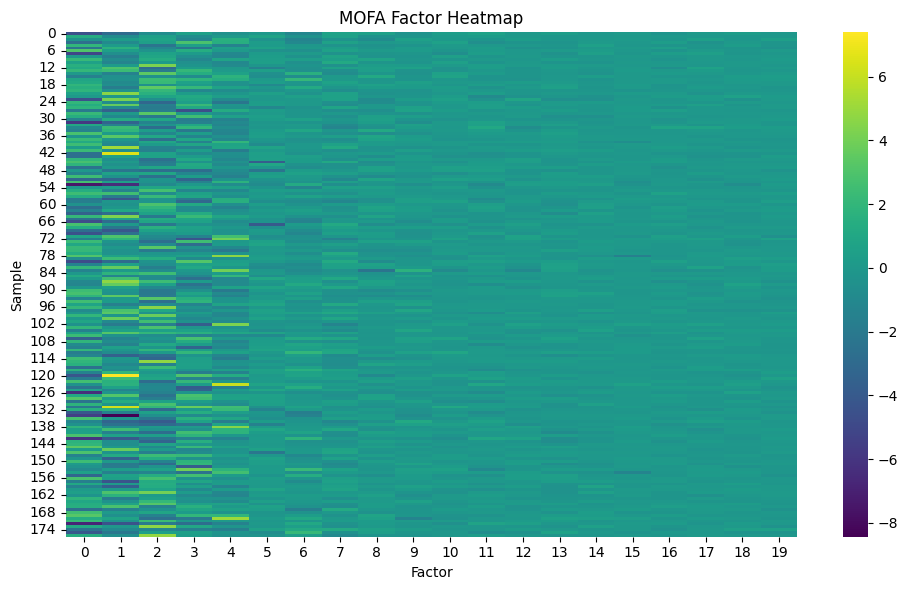

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)  # annot=False for large matrices
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


In [30]:
r2 = ent.model.calculate_variance_explained()

# Defensive fix for r2 indexing
if isinstance(r2, list) and len(r2) > 0 and isinstance(r2[0], dict):
    r2_total = r2[0]["r2_total"]
    r2_per_factor = r2[0]["r2_per_factor"]
else:
    r2_total = r2["r2_total"]
    r2_per_factor = r2["r2_per_factor"]

# Total variance explained per view
import matplotlib.pyplot as plt
plt.bar(range(len(r2_total)), r2_total)
plt.xticks(range(len(r2_total)), ["Expression","Methylation","CopyNumber","Protein"], rotation=45)
plt.ylabel("Variance Explained")
plt.title("Variance Explained per View")
plt.show()

# Variance explained per factor
import seaborn as sns
sns.heatmap(r2_per_factor, cmap="viridis")
plt.title("Variance Explained per Factor and View")
plt.show()


TypeError: list indices must be integers or slices, not str

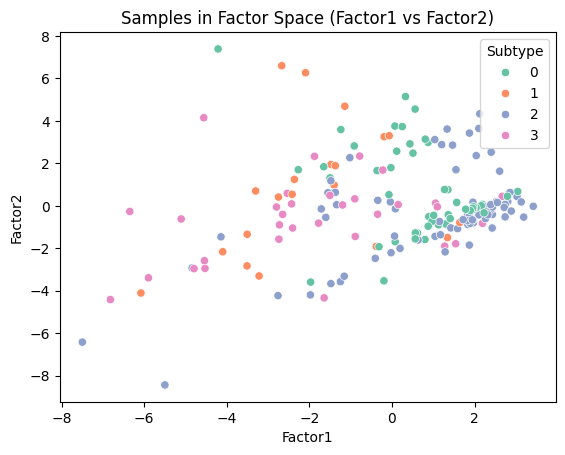

In [29]:
import seaborn as sns
factors_df = pd.DataFrame(factors, index=common_samples,
                          columns=[f"Factor{i+1}" for i in range(factors.shape[1])])
factors_df["Subtype"] = subtype_encoded.values

sns.scatterplot(data=factors_df, x="Factor1", y="Factor2", hue="Subtype", palette="Set2")
plt.title("Samples in Factor Space (Factor1 vs Factor2)")
plt.show()


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Factors: samples × factors
X = np.array(factors)   # shape (177, 20)

# Labels: subtype-encoded
y = subtype_encoded.loc[common_samples].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

# Predictions and accuracy
y_pred = clf_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred)
print('Logistic Regression accuracy:', acc_lr)

Logistic Regression accuracy: 0.7222222222222222


In [34]:
# 2. Random Forest on MOFA factors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print('Random Forest accuracy:', acc_rf)

Random Forest accuracy: 0.6111111111111112


In [35]:
# 3. Support Vector Machine (SVM) on MOFA factors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_svm = SVC(kernel='rbf', random_state=42)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred)
print('SVM accuracy:', acc_svm)

SVM accuracy: 0.7222222222222222


In [36]:
# 4. K-Nearest Neighbors (KNN) on MOFA factors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred)
print('KNN accuracy:', acc_knn)

KNN accuracy: 0.6944444444444444


In [37]:
# 5. Gradient Boosting (XGBoost) on MOFA factors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
try:
    from xgboost import XGBClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    clf_xgb.fit(X_train, y_train)
    y_pred = clf_xgb.predict(X_test)
    acc_xgb = accuracy_score(y_test, y_pred)
    print('XGBoost accuracy:', acc_xgb)
except ImportError:
    print('XGBoost is not installed. Please install xgboost to use this model.')

XGBoost accuracy: 0.6944444444444444


In [38]:
# 6. Naive Bayes on MOFA factors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred)
print('Naive Bayes accuracy:', acc_nb)

Naive Bayes accuracy: 0.6388888888888888


In [39]:
# Compare all 6 classifiers on MOFA factors: accuracy, F1 (macro/micro), precision, recall
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
from sklearn.model_selection import train_test_split
try:
    from xgboost import XGBClassifier
    xgb_installed = True
except ImportError:
    xgb_installed = False

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC(kernel='rbf', random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
    ("Naive Bayes", GaussianNB())
 ]
if xgb_installed:
    models.append(("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)))

results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    prec_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    rec_macro = recall_score(y_test, y_pred, average='macro')
    rec_micro = recall_score(y_test, y_pred, average='micro')
    results.append([name, acc, f1_macro, f1_micro, prec_macro, prec_micro, rec_macro, rec_micro])

import pandas as pd
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Macro", "F1 Micro", "Precision Macro", "Precision Micro", "Recall Macro", "Recall Micro"])
print(results_df.round(3))

                 Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Logistic Regression     0.722     0.658     0.722            0.686   
1        Random Forest     0.611     0.489     0.611            0.515   
2                  SVM     0.722     0.544     0.722            0.530   
3                  KNN     0.694     0.568     0.694            0.685   
4          Naive Bayes     0.639     0.507     0.639            0.506   
5              XGBoost     0.694     0.631     0.694            0.663   

   Precision Micro  Recall Macro  Recall Micro  
0            0.722         0.676         0.722  
1            0.611         0.490         0.611  
2            0.722         0.565         0.722  
3            0.694         0.567         0.694  
4            0.639         0.515         0.639  
5            0.694         0.624         0.694  
